# Exercises - GEO4902-03 - Ensemble Prediction

[Save as jupyter notebook, with your name in the filename, and upload on canvas]

# Exercise 03-02 - Ensemble prediction of a polar low

In [1]:
# import packages
import xarray as xr
import math
import numpy as np
import cartopy as cy
from matplotlib import pyplot as plt
from cmcrameri import cm

In [2]:
year =  '2020'
day  =  '03'
month = '02'
hour_1  ='18'

url='https://thredds.met.no/thredds/dodsC/meps25epsarchive/' +year+'/'+month+'/'+day+'/meps_extracted_2_5km_'+year+month+day+'T'+hour_1+'Z.nc'
forecast_1 = xr.open_dataset(url)

### Find a specific point and plot the forecast. 


In [3]:
def findindex(alat,alon,plat,plon):
    #finding identical location of pos plat, plon in array alat[],alon[]
    abslat = np.abs(alat-plat)
    abslon = np.abs(alon-plon)
    c = np.maximum(abslat,abslon)
    
    y, x = np.where(c == np.min(c))

    y=int(y[0])
    x=int(x[0])
   
    return (y,x)

In [4]:
[y_loc, x_loc] = findindex(forecast_1.latitude,forecast_1.longitude,69.649,18.956) # Tromsø

# print("Tromsø_forecast 1: latitude: {}; longitude: {}".format(forecast_1.latitude.isel(y=y_loc,x=x_loc).round(2), forecast_1.longitude.isel(y=y_loc,x=x_loc).round(2)))

# Plot of wind speed forecasts for Tromsø showing all ensemble members.

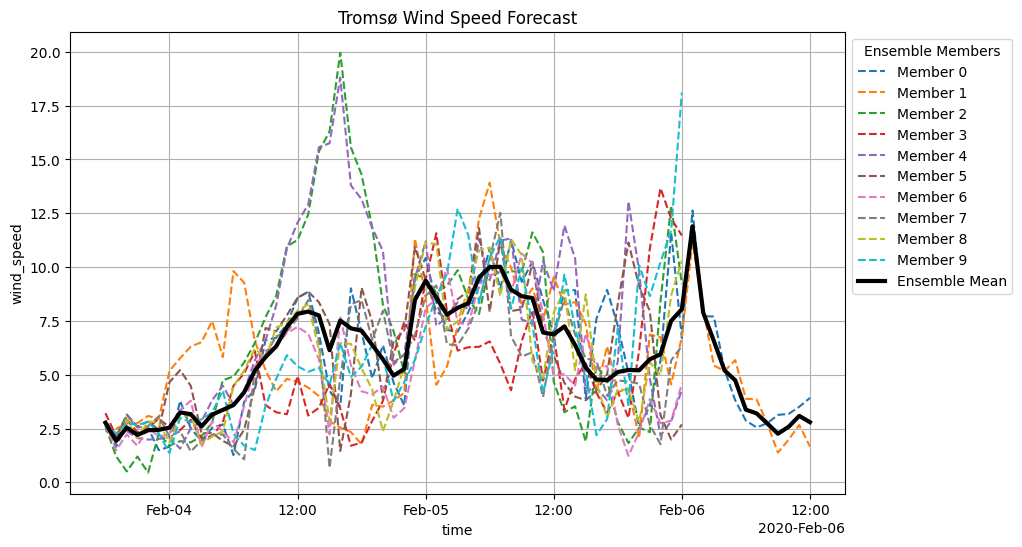

In [26]:
f, ax = plt.subplots(figsize=(10, 6))
for member in range(10):
    wind_point_forecast_1 = forecast_1['wind_speed'].isel(height3=0, ensemble_member=member, y=y_loc, x=x_loc)
    wind_point_forecast_1 = wind_point_forecast_1.assign_attrs({'long_name': 'Wind speed'}) #rename attribute of long name as it should be wind speed and not direction

    wind_point_forecast_1.plot.line(ax = ax, x='time', add_legend=False, label=f'Member {member}', linestyle='--')                             # plot with xarray.plot function

# calculate ensemble mean
wind_point_forecast = forecast_1['wind_speed'].isel(height3=0, y=y_loc, x=x_loc)
wind_point_forecast_mean = wind_point_forecast.mean(dim='ensemble_member')
wind_point_forecast_mean.plot.line(ax = ax,
                                   x='time',
                                   add_legend=False,
                                   linewidth=3,
                                   color='Black',
                                   label='Ensemble Mean') 
plt.grid(True)
plt.title("Tromsø Wind Speed Forecast")
ax.legend(title="Ensemble Members", loc='upper left', bbox_to_anchor=(1, 1))

# Lead time dependent forecast product

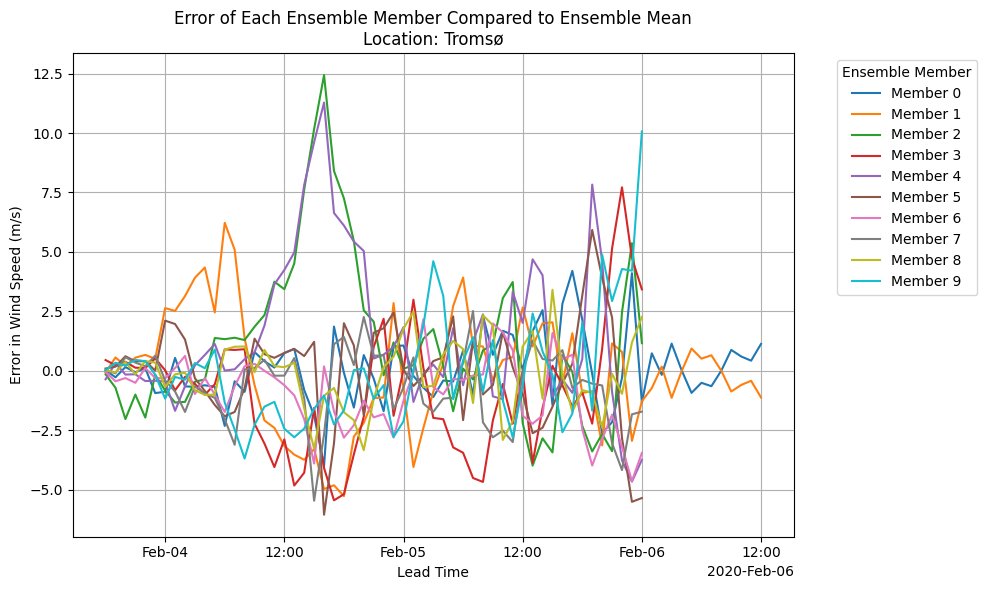

In [25]:
f, ax = plt.subplots(figsize=(10, 6))


# calculate error compared to ensemble mean
ensemble_error = wind_point_forecast - wind_point_forecast_mean

for member in range(10):
    member_error = ensemble_error.isel(ensemble_member=member)
    member_error.plot.line(x='time', add_legend=False, label=f'Member {member}')

plt.xlabel('Lead Time')
plt.ylabel('Error in Wind Speed (m/s)')
plt.title(f'Error of Each Ensemble Member Compared to Ensemble Mean\nLocation: Tromsø')
plt.legend(title="Ensemble Member", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()

plt.show()

Here the last hours can be disregarded since we only have two ensemble members. Up until this point, we notice that there are some members with large differences in the afternoon of the February 4th. Looking at the general trend in the absolute error for each member over lead time, we observe an increasing amplitude in the error oscillations.

This clearly indicates that the ensemble member error grows with lead time as would be expected. It should be noted, that here we assume the ensemble mean to reflect the true state. This holds if ensemble members and observations are drawn from the same distribution, but in reality this is probably not the case. Thus, a comparison to observations would yield a truer representation of error growth with lead time.

# Plot of the spread

Now the entire forecast will be considered, not just the Tromsø location.

$$
\text{ensemble spread} \equiv \left( \overline{s^2(t)} \right)^{1/2},
$$
where $s^2(t)$ is the variance.

In [9]:
wind_point_forecast = forecast_1['wind_speed'].isel(height3=0)

# Calculate the standard deviation over the ensemble members across the entire domain
ensemble_std_wind_speed = wind_point_forecast.std(dim='ensemble_member')


In [10]:
mean_ensemble_std_wind_speed = ensemble_std_wind_speed.mean(dim='time')

In [11]:
ensemble_spread = np.sqrt(mean_ensemble_std_wind_speed)

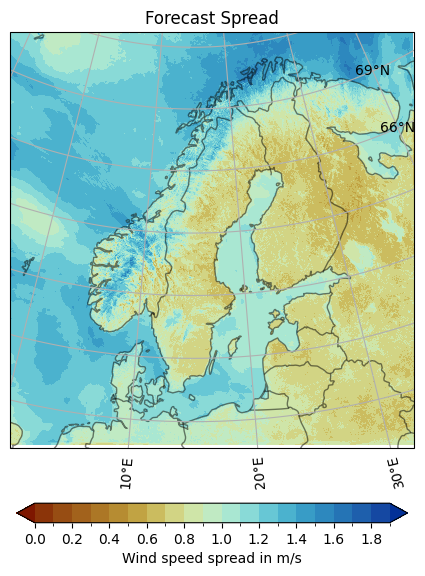

In [18]:
timestep = 20
mlevel = 0
member = 7


projection = cy.crs.Stereographic(central_latitude=75, central_longitude=15.0, )
f, axsm = plt.subplots(1,1, subplot_kw={'projection':projection}, figsize=[7.2, 7.2])

# plot cosmetics
axsm.set_extent([1, 32, 52, 72], cy.crs.PlateCarree())
axsm.add_feature(cy.feature.COASTLINE, alpha=0.5)
axsm.add_feature(cy.feature.BORDERS, alpha=0.5)
gl = axsm.gridlines(draw_labels=True)
gl.top_labels=False
gl.right_labels=True

ensemble_spread.plot.pcolormesh(ax=axsm, 
                                x='longitude', 
                                y='latitude',
                                cmap=cm.roma,
                                extend='both',
                                levels=np.arange(0,2, .1),
                                transform=cy.crs.PlateCarree(),
                                cbar_kwargs={'orientation':'horizontal','label':'Wind speed spread in m/s', 'shrink':0.7, 'pad':0.1})


plt.title ('Forecast Spread')
plt.show()

Notably, ocean and mountain regions seem to have the larges forecast spread for wind speed.

# Sea level pressure map for different ensemble members

The polar low is shown for 12:00 on February 4th 2020 since this is the peak wind magnitude for the ensemble mean of the Tromsø point forecast on the 4th.

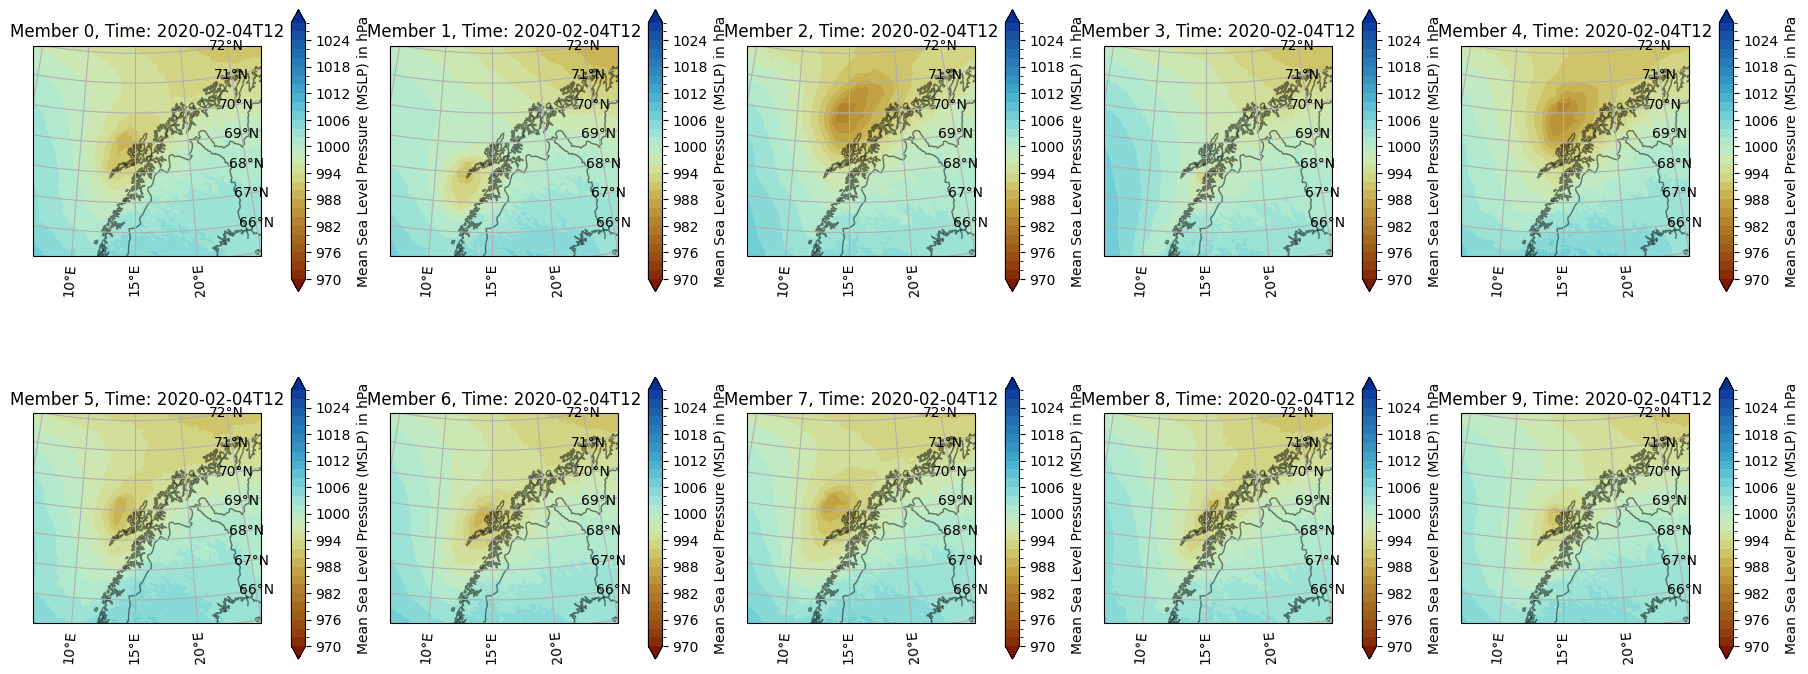

In [7]:
timestep = 18
mlevel = 0

# Define the projection for all subplots
projection = cy.crs.Stereographic(central_latitude=75, central_longitude=15.0)

# Create a figure with 2 rows and 5 columns for 10 ensemble members
f, axes = plt.subplots(2, 5, subplot_kw={'projection': projection}, figsize=[18, 8])

# Flatten axes array for easy iteration
axes = axes.flatten()

# Loop over the ensemble members
for member in range(10):
    axsm = axes[member]
    
    # Set plot extent and add features for each subplot
    axsm.set_extent([7, 25, 65, 72], cy.crs.PlateCarree())
    axsm.add_feature(cy.feature.COASTLINE, alpha=0.5)
    axsm.add_feature(cy.feature.BORDERS, alpha=0.5)
    
    # Configure gridlines
    gl = axsm.gridlines(draw_labels=True)
    gl.top_labels = False
    
    air_p = (forecast_1['air_pressure_at_sea_level'].isel(time=timestep,
                                                    height_above_msl=mlevel,
                                                    ensemble_member=member)/100)
    air_p.plot.pcolormesh(ax=axsm, 
                        x='longitude',
                        y='latitude',
                        cmap=cm.roma,
                        extend='both',
                        levels=np.arange(970,1030, 2),
                        transform=cy.crs.PlateCarree(),
                        cbar_kwargs={'orientation':'vertical','label':'{} in hPa'.format(forecast_1['air_pressure_at_sea_level'].attrs['long_name'],), 'shrink':0.7, 'pad':0.1})
    
    # Set the title for each subplot with the ensemble member number
    axsm.set_title(f"Member {member}, Time: {np.datetime_as_string(forecast_1.time[timestep], unit='h')}")

plt.tight_layout()

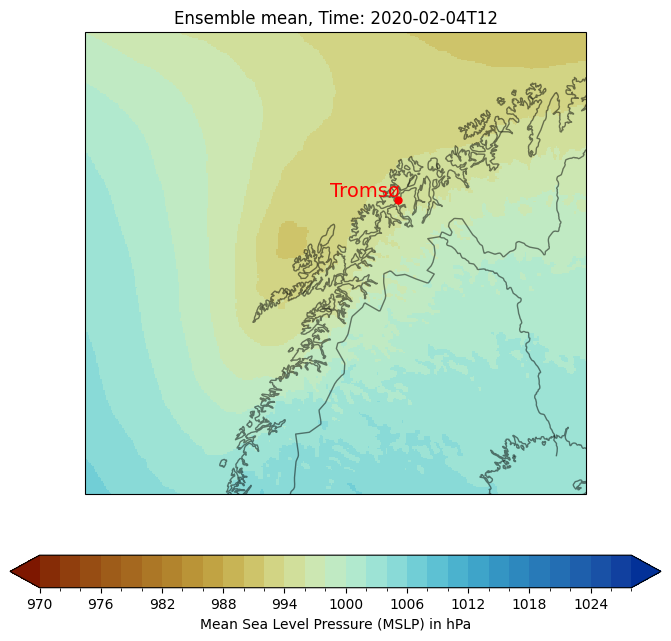

In [8]:
plt.figure(figsize=[12, 8])
ax = plt.axes(projection=projection)

# Set plot extent and add features
ax.set_extent([7, 25, 65, 72], cy.crs.PlateCarree())
ax.add_feature(cy.feature.COASTLINE, alpha=0.5)
ax.add_feature(cy.feature.BORDERS, alpha=0.5)
               
# ensmeble mean of pressure field
mean_air_p = (forecast_1['air_pressure_at_sea_level'].isel(time=timestep,
                                                    height_above_msl=mlevel).mean(dim='ensemble_member') / 100)

mean_air_p.plot.pcolormesh(ax=ax, 
                        x='longitude',
                        y='latitude',
                        cmap=cm.roma,
                        extend='both',
                        levels=np.arange(970, 1030, 2),
                        transform=cy.crs.PlateCarree(),
                        cbar_kwargs={'orientation': 'horizontal',
                                    'label': '{} in hPa'.format(forecast_1['air_pressure_at_sea_level'].attrs['long_name']),
                                    'shrink': 0.7, 
                                    'pad': 0.1})
# Add Tromsø marker
tromso_lon, tromso_lat = 18.956, 69.649
ax.plot(tromso_lon, tromso_lat, 'ro', markersize=5, transform=cy.crs.PlateCarree())
ax.text(tromso_lon - 3.0, tromso_lat + 0.1, 'Tromsø', fontsize=14, color='red', transform=cy.crs.PlateCarree())
ax.set_title(f"Ensemble mean, Time: {np.datetime_as_string(forecast_1.time[timestep], unit='h')}")
plt.show()

Here the ensemble mean pressure field is used to show the position of the polar low by using the forecast information of all 10 ensemble members.